# Обучение сиамской сети для различия двух объектов

Обучение на данных MOT20Ext

In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import Generator, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torchvision import models
from tqdm import tqdm
from os.path import join
from copy import deepcopy
from datetime import datetime

from src.config import (IMAGENET_MEAN, IMAGENET_STD, MOT20_EXT_FIRST_AXIS_MEAN,
                        MOT20_EXT_SECOND_AXIS_MEAN, DATA_PATH)
from src.data import MOT20ExtDataset
from src.models import SiameseBasicCNN, SiameseTransfered
from src.train import display_batch, display_images, get_statistics, ContrastiveLoss
from src.transforms import get_norm_transform, get_resize_transform

/home/nick/reidentification/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Загрузка данных

In [2]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [3]:
dataset01 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-01/'), transform=transform)
dataset02 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-02/'), transform=transform)
dataset03 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-03/'), transform=transform)
dataset05 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-05/'), transform=transform)

In [4]:
dataset = ConcatDataset([dataset01, dataset02, dataset03, dataset05])

In [5]:
len(dataset)

271442

### Создание даталоадеров

In [6]:
TEST_PROPROTION = 0.2
VAL_PROPORTION = 0.15
TRAIN_PROPORTION = 1 - TEST_PROPROTION - VAL_PROPORTION
sum([TEST_PROPROTION, VAL_PROPORTION, TRAIN_PROPORTION])

1.0

In [7]:
generator = torch.manual_seed(0)
dataset_use, dataset_unuse = random_split(dataset, [0.002, 0.998])
len(dataset_use)

543

In [8]:
train_set, val_set, test_set = random_split(
    dataset_use, [TRAIN_PROPORTION, VAL_PROPORTION, TEST_PROPROTION], generator=generator)

In [9]:
len(train_set), len(val_set), len(test_set)

(353, 82, 108)

In [10]:
BATCH_SIZE = 16

In [11]:
train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator,
    
)

val_loader = DataLoader(
    val_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator
)

test_loader = DataLoader(
    test_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator
)

In [12]:
len(train_loader), len(val_loader), len(test_loader)

(22, 5, 6)

### Расчет статистик

In [13]:
loader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator,
)

In [14]:
# get_statistics(loader)

### Проверка отображения

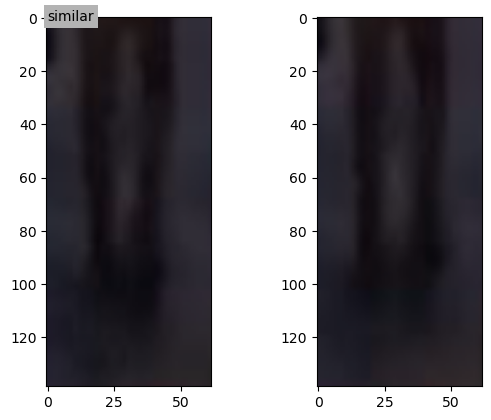

In [15]:
batch = next(iter(train_loader))
x1, x2, y = batch[0][0], batch[1][0], batch[2][0]
display_images((x1, x2), y)

In [16]:
# batch = next(iter(train_loader))
# display_batch(batch)

## Обучение

### DEBUG - Delete after

In [22]:
resnet18 = models.resnet18(pretrained=True)


### Настройка моделей

In [21]:
def resnet_grad_linear_unlock(model: nn.Module):
    for x in model.parameters():
            x.requires_grad = False
    for x in model.fc.parameters():
        x.requires_grad = True

def resnet_grad_l4_unlock(model: nn.Module):
    for x in model.parameters():
            x.requires_grad = False
    for x in model.layer4.parameters():
        x.requires_grad = True
    for x in model.fc.parameters():
        x.requires_grad = True

In [24]:
model_rn18_linear = SiameseTransfered(
    resnet18,
    freeze_grad_fn=resnet_grad_linear_unlock,
    name='siamese_resnet18_linear'
)

model_rn18_l4 = SiameseTransfered(
    resnet18,
    freeze_grad_fn=resnet_grad_l4_unlock,
    name='siamese_resnet18_linear'
)

### Обучение Siamese over ResNet18, layer4 unfreeze

Параметры:
- Adam
- ContrastiveLoss
- Threshold = 0.25
- LR = 0.001 

In [25]:
lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(model_rn18_l4.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, results = train(
    model=model_rn18_l4,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=4,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/3:


100%|██████████| 22/22 [00:36<00:00,  1.66s/it]

train Loss: 856.7153 Acc: 0.8324



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

val Loss: 60.4530 Acc: 0.9375
Model saved at siamese_resnet18_linear.pth
Epoch 1/3:



100%|██████████| 22/22 [00:33<00:00,  1.54s/it]

train Loss: 21.0212 Acc: 0.8977



100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

val Loss: 16.1600 Acc: 0.9750
Model saved at siamese_resnet18_linear.pth
Epoch 2/3:



100%|██████████| 22/22 [00:31<00:00,  1.41s/it]

train Loss: 12.5394 Acc: 0.9062



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

val Loss: 10.9229 Acc: 0.9500
Epoch 3/3:



100%|██████████| 22/22 [00:30<00:00,  1.38s/it]

train Loss: 8.9757 Acc: 0.8892



100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

val Loss: 8.2460 Acc: 0.9625


In [ ]:
model = SiameseBasicCNN2()
lr = 1e-2
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, results = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=3,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/2:


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]

train Loss: 2298.1805 Acc: 0.7301



100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

val Loss: 1708.0820 Acc: 0.7250
Model saved at resnet_l4.pth
Epoch 1/2:



100%|██████████| 22/22 [00:11<00:00,  1.95it/s]

train Loss: 993.2562 Acc: 0.7273



100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

val Loss: 917.9447 Acc: 0.7875
Model saved at resnet_l4.pth
Epoch 2/2:



100%|██████████| 22/22 [00:10<00:00,  2.00it/s]

train Loss: 533.1695 Acc: 0.7642



100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

val Loss: 474.1536 Acc: 0.7125


In [ ]:
model = SiameseBasicCNN3()
lr = 0.1
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model, results = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=10,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/9:


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 11.2927 Acc: 0.6818



100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

val Loss: 2.4559 Acc: 0.9000
Model saved at basic_cnn.pth
Epoch 1/9:



100%|██████████| 22/22 [00:24<00:00,  1.09s/it]

train Loss: 1.4874 Acc: 0.6619



100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

val Loss: 1.5503 Acc: 0.8250
Epoch 2/9:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 1.3579 Acc: 0.6818



100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

val Loss: 1.6998 Acc: 0.8625
Epoch 3/9:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

train Loss: 1.3846 Acc: 0.6705



100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

val Loss: 1.4850 Acc: 0.9375
Model saved at basic_cnn.pth
Epoch 4/9:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

train Loss: 1.4048 Acc: 0.7273



100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

val Loss: 1.5470 Acc: 0.8125
Epoch 5/9:



100%|██████████| 22/22 [00:25<00:00,  1.18s/it]

train Loss: 1.4186 Acc: 0.7216



100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

val Loss: 1.7108 Acc: 0.8500
Epoch 6/9:



100%|██████████| 22/22 [00:24<00:00,  1.11s/it]

train Loss: 1.4180 Acc: 0.7045



100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

val Loss: 1.5746 Acc: 0.7250
Epoch 7/9:



100%|██████████| 22/22 [00:23<00:00,  1.06s/it]

train Loss: 1.3072 Acc: 0.6477



100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

val Loss: 1.5091 Acc: 0.9125
Epoch 8/9:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 1.3695 Acc: 0.6705



100%|██████████| 5/5 [00:00<00:00,  7.79it/s]

val Loss: 1.4572 Acc: 0.9375
Epoch 9/9:



100%|██████████| 22/22 [00:23<00:00,  1.09s/it]

train Loss: 1.4502 Acc: 0.7415



100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

val Loss: 1.5912 Acc: 0.7750


In [26]:
def draw_plot(y1, y2, label):
    epoch = range(len(y1))
    fig, ax = plt.subplots()
    ax.plot(epoch, y1, label=f'{label} loss')
    ax.plot(epoch, y2, label=f'{label} accuracy')
    ax.grid()
    plt.xlabel('epoch count')
    plt.ylabel('metrics')
    plt.title(label)
    plt.legend()
    fig.savefig("test.png")
    plt.show()

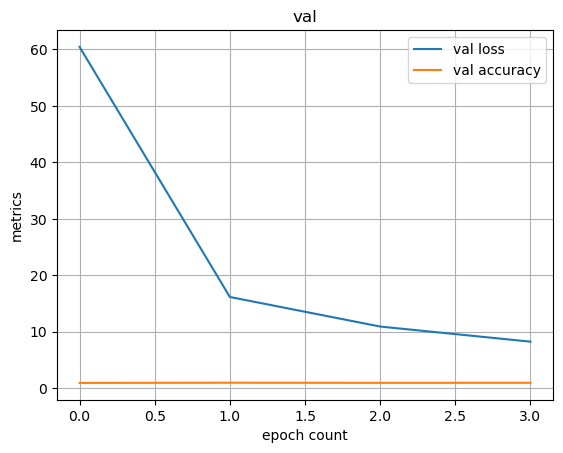

In [27]:
draw_plot(results['val'][0], results['val'][1], 'val')